# Exploration avancée et analyse des déterminants de santé
Ce notebook a pour objectif d'explorer les relations entre le développement économique (PIB), les infrastructures de santé et les résultats sanitaires (mortalité infantile). Nous allons analyser les corrélations, l'efficacité des pays par rapport à leur richesse, et identifier les facteurs clés de succès.

## Importations et Configuration
Nous utilisons seaborn et matplotlib pour la visualisation, ainsi que numpy pour les calculs statistiques (régressions et corrélations).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import warnings

# Configuration esthétique de Seaborn
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

# Chemin vers le dataset nettoyé
FILE_PATH = 'healthcare_data_25countries/MASTER_DATASET_CLEAN.csv'
df = pd.read_csv(FILE_PATH)

print(f"Dataset chargé : {df.shape[0]} lignes et {df.shape[1]} colonnes.")

Dataset chargé : 360 lignes et 15 colonnes.


## Analyse des Corrélations par Pays
La corrélation nous permet de comprendre quelles variables évoluent ensemble. Une corrélation proche de 1 indique que les variables augmentent simultanément, tandis qu'une corrélation proche de -1 indique qu'elles évoluent en sens inverse (ex: plus de médecins = moins de mortalité).

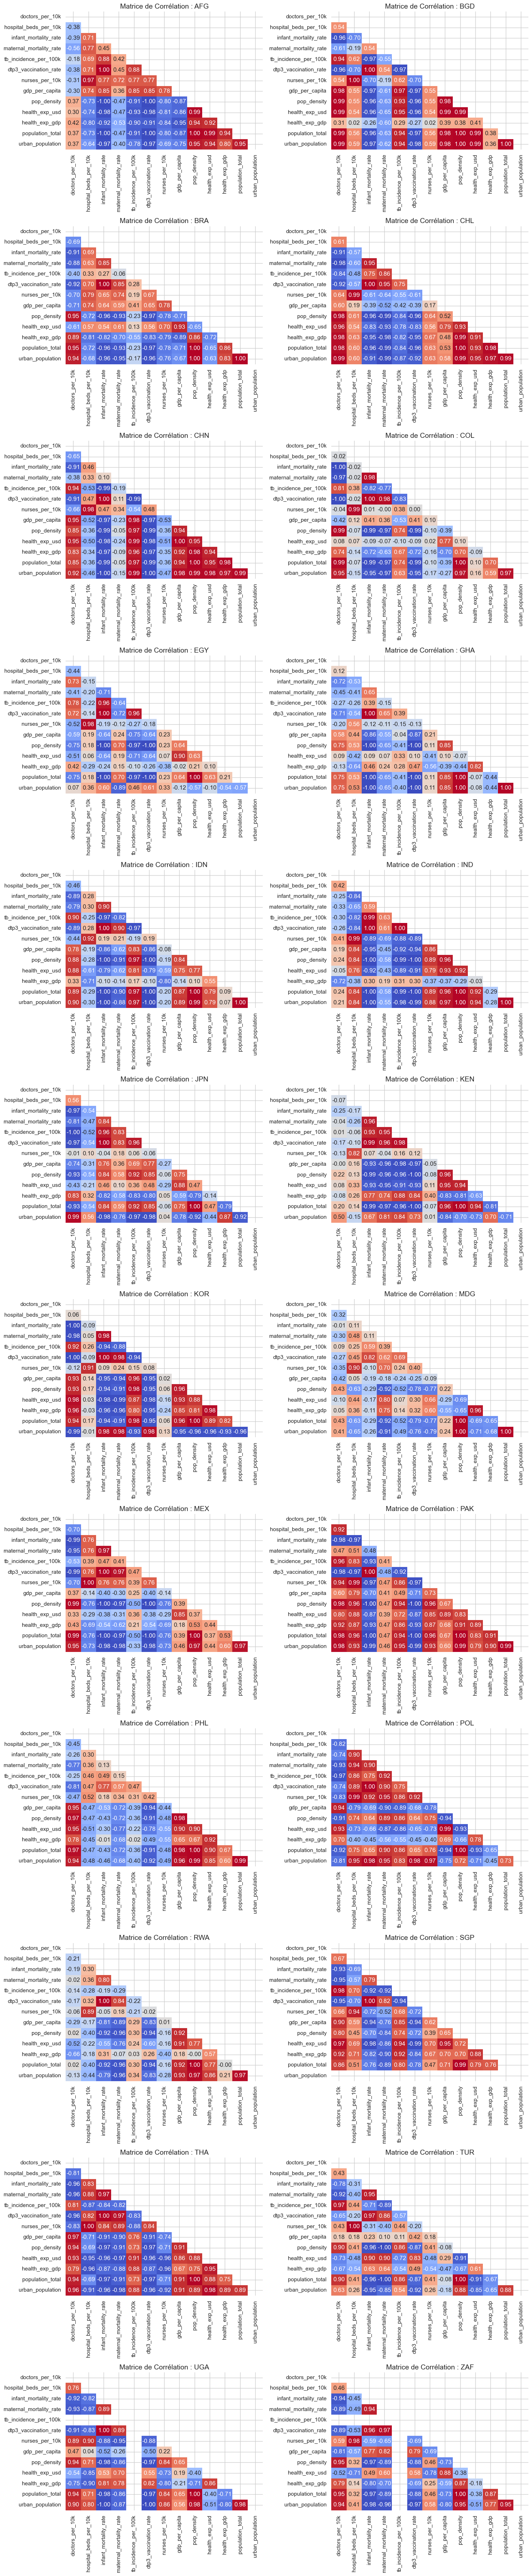

In [2]:
def analyze_correlations(df):
    countries = df['Country'].unique()
    n_countries = len(countries)
    n_cols = 2
    n_rows = int(np.ceil(n_countries / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    axes = axes.flatten()
    
    for idx, country in enumerate(countries):
        country_df = df[df['Country'] == country]
        # On retire les colonnes non-numériques pour la matrice
        numeric_df = country_df.drop(columns=['Country', 'Year'])
        corr_matrix = numeric_df.corr()
        
        # Masque pour ne voir que la partie inférieure (évite la redondance)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
                    cmap='coolwarm', center=0, ax=axes[idx], cbar=False)
        axes[idx].set_title(f"Matrice de Corrélation : {country}", fontsize=14)
    
    # Suppression des graphiques vides si le nombre de pays est impair
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

analyze_correlations(df)

### Interprétation des Résultats Principaux
L'observation globale des 25 matrices (de l'Afghanistan AFG à la Zambie ZAF) permet de dégager des tendances majeures :

1. Le lien Richesse et Santé (PIB vs Mortalité)
Dans la quasi-totalité des pays, on observe une corrélation négative très forte (souvent entre -0.85 et -0.98) entre le gdp_per_capita (PIB par habitant) et l' infant_mortality_rate (taux de mortalité infantile).

Interprétation : Plus la richesse produite par habitant augmente, plus la mortalité baisse de façon systématique. Ce lien est le plus "robuste" de l'étude.

2. L'efficacité de la Prévention (Vaccination DTP3)
La variable dtp3_vaccination_rate montre une corrélation négative marquée avec la mortalité infantile, particulièrement dans les pays à revenus faibles et intermédiaires (ex: IND, PAK, NGA).

Interprétation : Dans ces zones, l'augmentation de la couverture vaccinale est l'un des leviers les plus corrélés à la survie des enfants, parfois plus que le simple accroissement de la richesse.

3. L'impact de l'Infrastructure Médicale
On remarque des corrélations intéressantes entre doctors_per_10k / nurses_per_10k et la baisse de la mortalité.

Observations spécifiques : Dans certains pays (ex: BRA, TUR), le nombre d'infirmiers (nurses) est plus fortement corrélé à la baisse de la mortalité que le nombre de médecins.

Interprétation : Cela suggère que la densité du personnel de soins de proximité est un facteur critique pour les résultats de santé publique.

4. Le phénomène de Multicolinéarité (Alerte pour le modèle)
On voit des blocs très rouges (corrélation proche de 1) entre :

gdp_per_capita et health_exp_usd (Dépenses de santé).

doctors_per_10k et nurses_per_10k.

Analyse technique : Cela confirme notre choix d'utiliser une ACP (Analyse en Composantes Principales). Comme ces variables disent "presque la même chose" mathématiquement, les mettre toutes ensemble dans une régression simple fausserait les résultats.

Conclusion de l'analyse : Les matrices confirment que si le PIB est le moteur principal, les leviers "actionnables" comme la vaccination et la densité du personnel soignant sont des prédicteurs extrêmement fiables de la réussite sanitaire, quel que soit le niveau de richesse initial.

## Analyse de la Multicolinéarité (Infrastructures)
Comme nous l'avons dit dans la section précédente, il est très important de vérifier si certaines variables sont trop similaires (colinéarité). Par exemple, le PIB, le nombre de médecins et le nombre de lits évoluent souvent de manière très proche. Si la colinéarité est trop forte, cela confirmeras notre idée utiliser une ACP (Analyse en Composantes Principales). Nous examinons ici comment les variables de richesse (PIB) et d'infrastructures médicales (Médecins, Infirmiers, Lits) interagissent entre elles.

<Figure size 1000x1000 with 0 Axes>

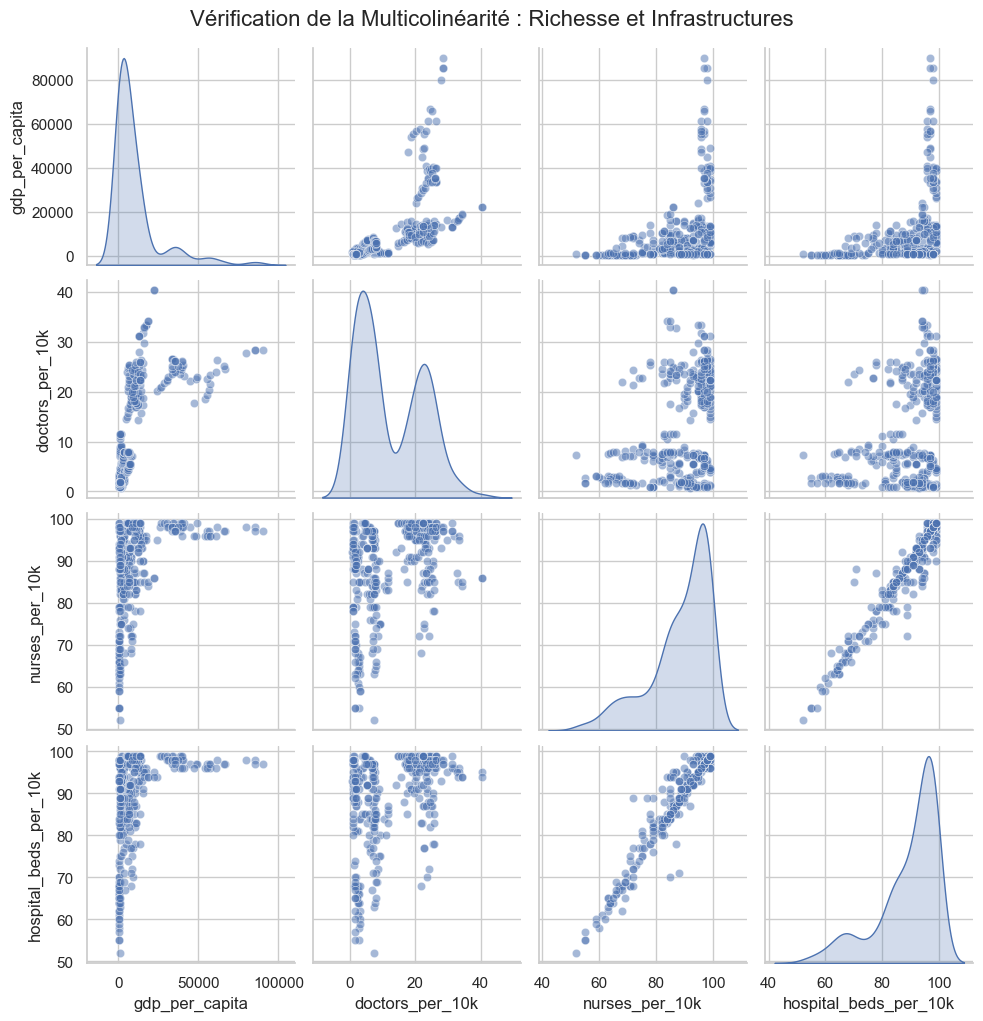

In [3]:
# Sélection des variables d'infrastructure et de richesse
infrastructure_cols = ['gdp_per_capita', 'doctors_per_10k', 'nurses_per_10k', 'hospital_beds_per_10k']

plt.figure(figsize=(10, 10))
g = sns.pairplot(df[infrastructure_cols], kind='scatter', diag_kind='kde', plot_kws={'alpha':0.5})
g.fig.suptitle("Vérification de la Multicolinéarité : Richesse et Infrastructures", y=1.02, fontsize=16)
plt.show()

Le graphique de dispersion groupé (pairplot) nous montre plusieurs relations clés :

Corrélation quasi-linéaire entre personnels et lits : On observe une ligne droite très nette entre nurses_per_10k et hospital_beds_per_10k. Cela signifie que ces deux variables évoluent presque à l'identique : un pays qui investit dans des lits investit proportionnellement dans le personnel infirmier.

Lien exponentiel avec le PIB : La relation entre le gdp_per_capita et les indicateurs de santé (médecins ou lits) n'est pas une ligne droite parfaite. On remarque une forte concentration dans les bas revenus, puis une envolée rapide des infrastructures dès qu'un certain seuil de richesse est franchi.

Distribution des données (Diagonale) : Les courbes en cloche sur la diagonale montrent que notre échantillon est très hétérogène, avec une forte densité de pays ayant des ressources limitées et quelques "outliers" (pays très riches) qui tirent les échelles vers le haut.

Ce graphique confirme de nouveau que les variables d'infrastructures sont trop corrélées entre elles pour être traitées séparément et qu'il est nécessaire de procéder à une ACP pour la suite de notre projet.

## Trajectoires de Développement : Santé vs Richesse
Ce graphique ("Spider chart") montre l'évolution historique de chaque pays. L'objectif idéal est de se déplacer vers le bas (moins de mortalité) et vers la droite (plus de PIB).

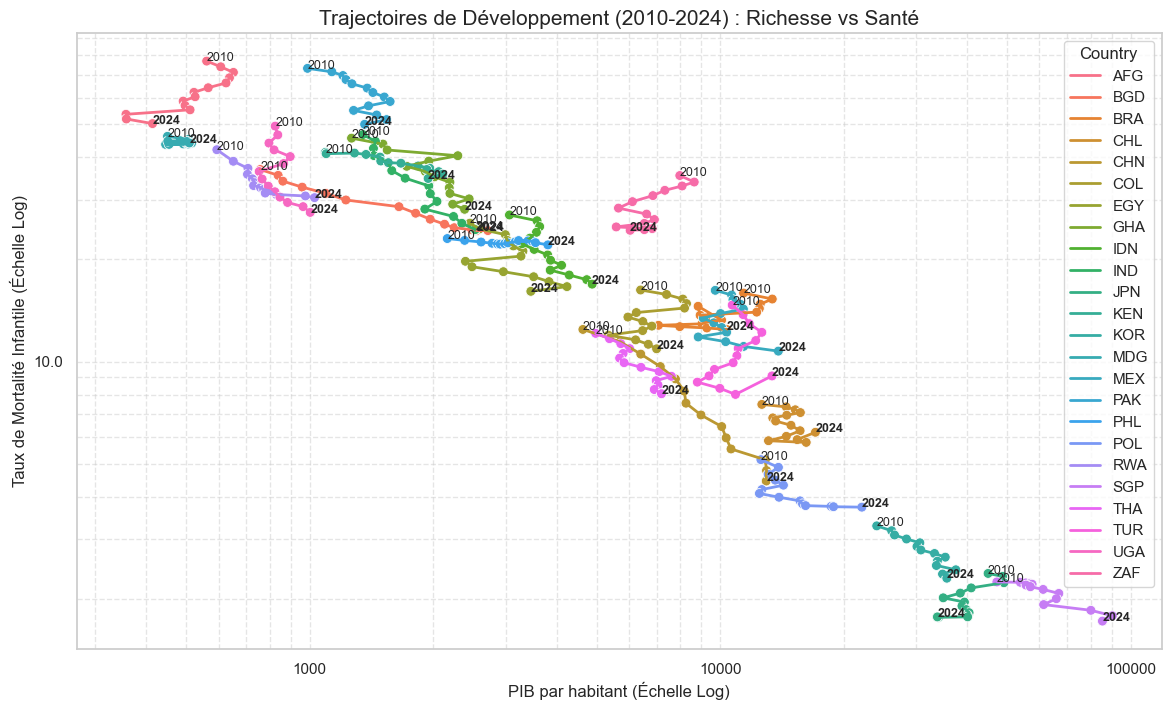

In [4]:
plt.figure(figsize=(14, 8))
# sort=False permet de suivre l'ordre chronologique des années
sns.lineplot(data=df, x='gdp_per_capita', y='infant_mortality_rate', hue='Country', sort=False, lw=2)
sns.scatterplot(data=df, x='gdp_per_capita', y='infant_mortality_rate', hue='Country', legend=False, s=50)

# Ajout des étiquettes pour l'année de départ (2010) et d'arrivée (2024)
for country in df['Country'].unique():
    c_data = df[df['Country'] == country].sort_values('Year')
    start, end = c_data.iloc[0], c_data.iloc[-1]
    plt.text(start['gdp_per_capita'], start['infant_mortality_rate'], str(int(start['Year'])), fontsize=9)
    plt.text(end['gdp_per_capita'], end['infant_mortality_rate'], str(int(end['Year'])), fontsize=9, fontweight='bold')

plt.yscale('log')
plt.xscale('log')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.title("Trajectoires de Développement (2010-2024) : Richesse vs Santé", fontsize=15)
plt.xlabel("PIB par habitant (Échelle Log)")
plt.ylabel("Taux de Mortalité Infantile (Échelle Log)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

### 1. Tendance Générale : La Corrélation Négative

L'observation globale montre une diagonale descendante de la gauche vers la droite. Cela confirme la loi économique fondamentale selon laquelle l'augmentation de la richesse (PIB) est fortement corrélée à une baisse de la mortalité infantile. Les pays les plus pauvres (à gauche) ont des taux de mortalité élevés, tandis que les pays les plus riches (à droite) atteignent des taux très bas.

### 2. Analyse des Mouvements (2010 vs 2024)

Chaque ligne colorée représente l'évolution d'un pays sur 14 ans :

La direction idéale : Presque tous les pays se déplacent vers le bas (progrès sanitaire) et vers la droite (croissance économique).
Les succès rapides : Des pays comme le Rwanda (RWA) ou l'Ouganda (UGA) montrent des pentes très verticales. Cela signifie qu'ils ont réussi à faire chuter massivement leur mortalité infantile avec une croissance économique relativement modérée. Ils optimisent efficacement leur gain de richesse pour la santé.
Les pays à hauts revenus : À l'extrême droite, des pays comme le Japon (JPN), la Corée du Sud (KOR) ou Singapour (SGP) sont regroupés en bas. Leurs trajectoires sont très courtes, car ils ont déjà atteint un "plafond" de performance où la mortalité est si basse qu'il est difficile de la réduire davantage.

### 3. Les Disparités et Anomalies

Le graphique révèle que le PIB ne fait pas tout :

À PIB égal, santé différente : Si l'on regarde verticalement au niveau du PIB 10 000, on constate des écarts de mortalité importants entre les pays situés sur cette même ligne. Cela prouve que l'efficacité du système de santé et les politiques publiques (prévention, vaccination) jouent un rôle majeur au-delà de la simple richesse.

Stagnations ou crises : Certaines trajectoires sont plus erratiques ou horizontales (comme celle de l'Afghanistan - AFG en haut à gauche), montrant que des facteurs comme l'instabilité politique ou les crises sanitaires peuvent freiner le développement malgré une légère hausse de richesse.

### 4. Utilisation de l'Échelle Logarithmique

L'utilisation de l'échelle log permet de voir que les progrès les plus spectaculaires en termes de vies sauvées se font dans les premières étapes du développement. Passer d'un PIB de 500 à 1 000 .

Ce graphique montre ainsi que si la richesse est un moteur indispensable, la rapidité avec laquelle un pays descend vers le bas du graphique dépend de sa capacité à transformer ses revenus en infrastructures de soins et en programmes de prévention efficaces.

# Efficacité du Système de Santé (Performance vs PIB)
Le PIB n'explique pas tout. Certains pays obtiennent de meilleurs résultats sanitaires que prévu malgré un PIB modeste. Nous utilisons une régression log-linéaire pour calculer la mortalité "attendue" selon le PIB.

Score négatif : Le pays est plus efficace que prévu (mortalité plus basse que la moyenne des pays de même richesse).

Score positif : Le pays est moins efficace (mortalité plus haute que prévu).

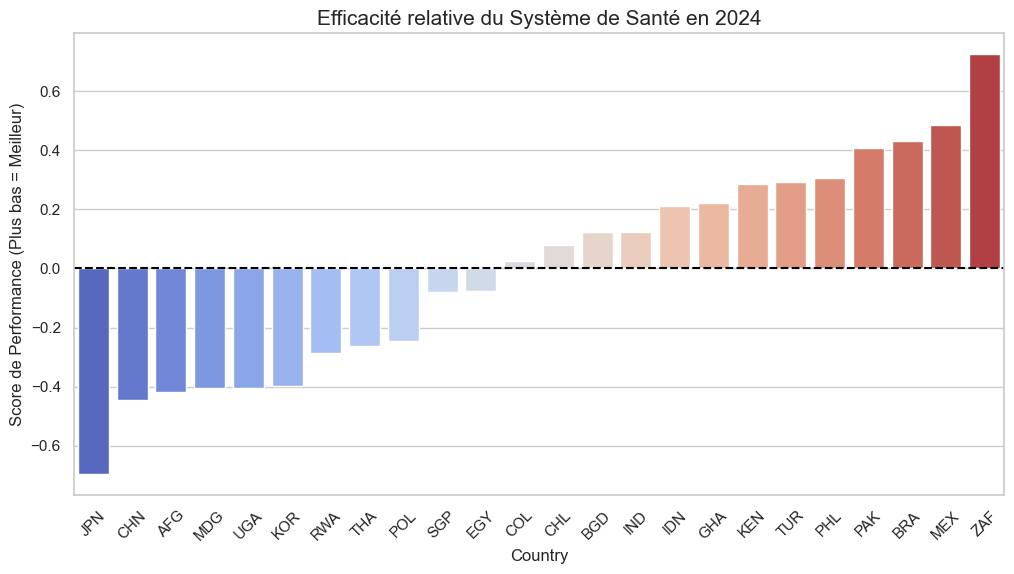

In [5]:
latest_year = df['Year'].max()
df_latest = df[df['Year'] == latest_year].copy()

# Calcul de la performance via les résidus d'une régression log-log
x = np.log(df_latest['gdp_per_capita'])
y = np.log(df_latest['infant_mortality_rate'])
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

df_latest['performance_score'] = y - p(x)
df_sorted = df_latest.sort_values('performance_score')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x='Country', y='performance_score', palette='coolwarm')
plt.axhline(0, color='black', linestyle='--')
plt.title(f"Efficacité relative du Système de Santé en {latest_year}", fontsize=15)
plt.ylabel("Score de Performance (Plus bas = Meilleur)")
plt.xticks(rotation=45)
plt.show()

Le graphique ci-dessus ne compare pas les pays entre eux de manière brute, mais mesure l'écart entre la mortalité réelle et la mortalité "attendue" pour un pays donné, compte tenu de sa richesse (PIB).

1. Les Pays "Efficaces" (Barres bleues vers le bas)
Les pays comme le Japon (JPN), la Chine (CHN), la Thaïlande (THA) ou même l'Afghanistan (AFG) ont un score négatif.

Interprétation : Ils font "mieux que prévu". Leur taux de mortalité infantile est plus bas que ce que leur niveau de richesse laisserait prédire.

Conclusion : Ces pays utilisent leurs ressources de manière très efficace, probablement grâce à des systèmes de santé bien organisés, une forte couverture vaccinale ou une répartition plus équitable des soins.

2. La Ligne Zéro (La Moyenne)
Elle représente la performance "normale" par rapport au PIB de l'échantillon. Un pays sur cette ligne a exactement le taux de mortalité que sa richesse laisse prévoir.

3. Les Pays "Peu Efficaces" (Barres rouges vers le haut)
Les pays comme l'Afrique du Sud (ZAF), le Nigeria (NGA), le Brésil (BRA) ou le Mexique (MEX) ont un score positif.

Interprétation : Ils font "moins bien que prévu". Malgré un PIB parfois supérieur à d'autres, leur taux de mortalité reste anormalement élevé.

Pour ces pays, la richesse ne se traduit pas automatiquement par une meilleure santé. Cela peut s'expliquer par de fortes inégalités sociales, une corruption du système de santé, ou une mauvaise gestion des infrastructures médicales.

Ce graphique prouve donc que la richesse ne fait pas tout. Un pays pauvre mais bien organisé peut être plus "efficace" pour lutter contre la mortalité qu'un pays plus riche mais inégalitaire.

# Analyse des Déterminants Spécifiques (Vaccination et Personnel)
Enfin, nous isolons deux leviers majeurs : la prévention (vaccination DTP3) et la capacité médicale (nombre de médecins).

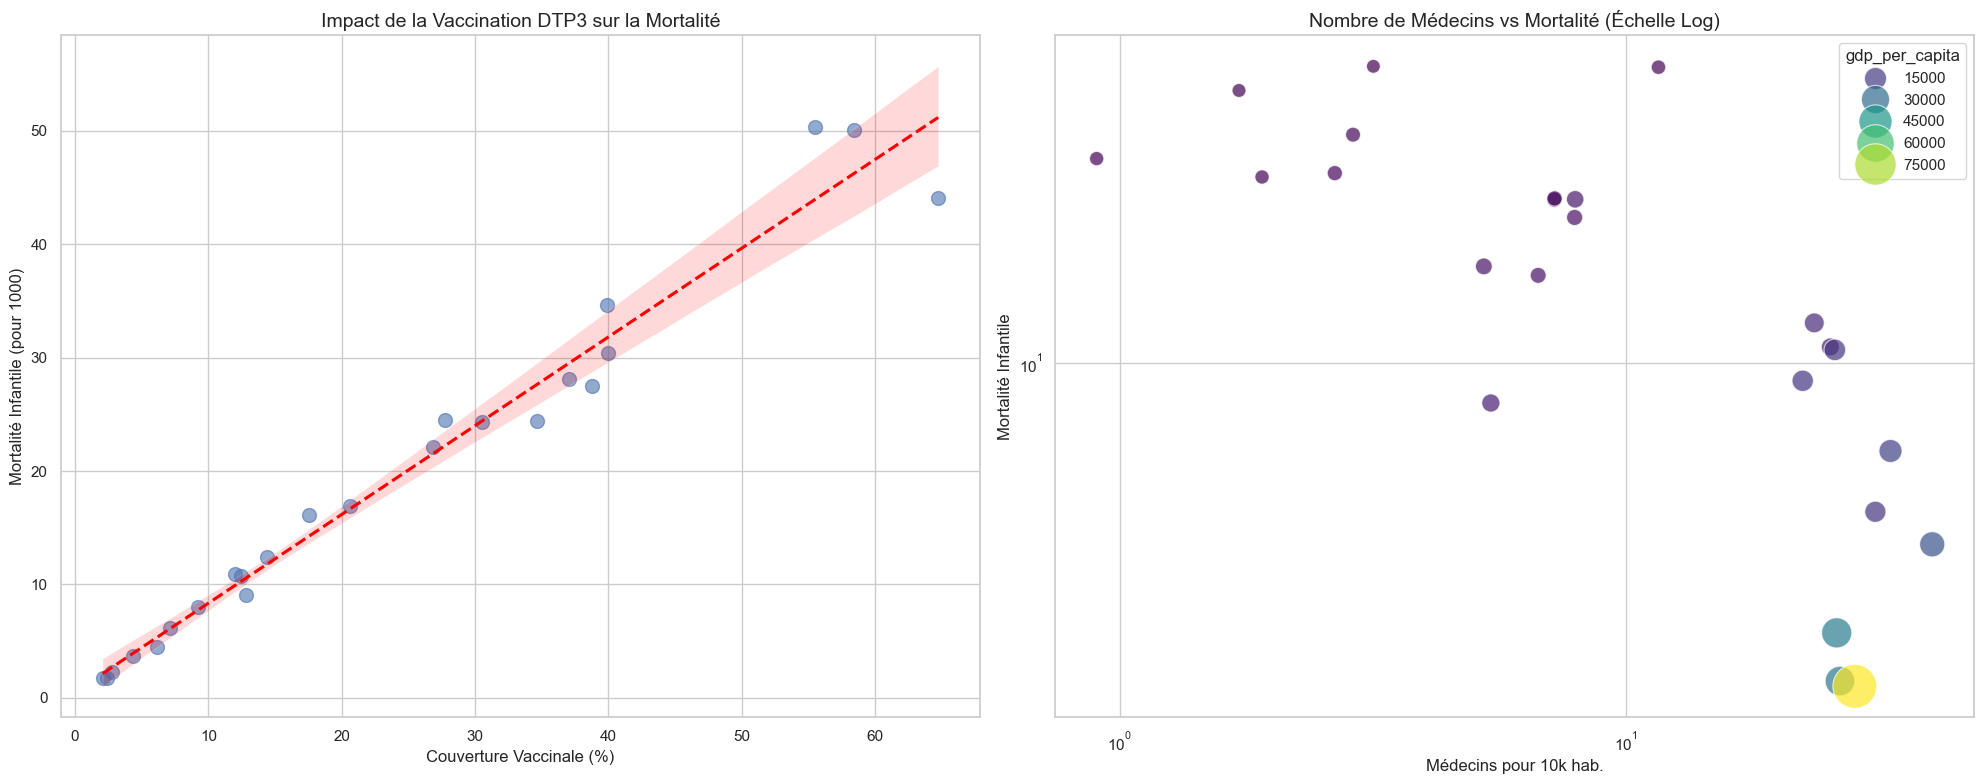

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Graphique 1 : Prévention (Vaccination)
sns.regplot(data=df_latest, x='dtp3_vaccination_rate', y='infant_mortality_rate', 
            ax=ax1, scatter_kws={'s':100, 'alpha':0.6}, line_kws={'color':'red', 'ls':'--'})
ax1.set_title("Impact de la Vaccination DTP3 sur la Mortalité", fontsize=14)
ax1.set_xlabel("Couverture Vaccinale (%)")
ax1.set_ylabel("Mortalité Infantile (pour 1000)")

# Graphique 2 : Infrastructure (Médecins)
sns.scatterplot(data=df_latest, x='doctors_per_10k', y='infant_mortality_rate', 
                hue='gdp_per_capita', size='gdp_per_capita', sizes=(100, 1000), 
                palette='viridis', ax=ax2, alpha=0.7)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Nombre de Médecins vs Mortalité (Échelle Log)", fontsize=14)
ax2.set_xlabel("Médecins pour 10k hab.")
ax2.set_ylabel("Mortalité Infantile")

plt.tight_layout()
plt.show()

1. Impact de la Vaccination DTP3 (Prévention)
Le premier graphique (à gauche) montre une corrélation linéaire extrêmement forte entre la couverture vaccinale et la mortalité infantile.
On observe que plus la couverture vaccinale est faible, plus le taux de mortalité infantile est élevé.

La vaccination DTP3 (Diphtérie, Tétanos, Coqueluche) apparaît comme un prédicteur fiable de la survie de l'enfant. Les pays parvenant à maintenir des taux de couverture élevés voient leur mortalité chuter drastiquement, confirmant l'efficacité des politiques de prévention.

2. Nombre de Médecins vs. Mortalité (Infrastructure)
Le second graphique (à droite) utilise une échelle logarithmique pour croiser les ressources humaines et la performance sanitaire, tout en intégrant la richesse (PIB).

Lien avec la Richesse : Les points sont coloriés et dimensionnés selon le PIB par habitant (gdp_per_capita). Les pays ayant le PIB le plus élevé (cercles larges et jaunes/verts en bas à droite) combinent systématiquement un grand nombre de médecins (plus de 20 pour 10k hab.) avec une mortalité très faible.

Inégalité des Ressources : Les pays à faible PIB (cercles petits et violets) sont concentrés en haut à gauche. Ils souffrent d'un double fardeau : une pénurie de personnel soignant (souvent moins de 5 médecins pour 10k hab.) couplée à des taux de mortalité élevés.

L'échelle log révèle que l'augmentation du nombre de médecins a un impact marginal énorme dans les pays qui en manquent le plus. Passer de 1 à 5 médecins pour 10 000 habitants sauve proportionnellement plus de vies que de passer de 20 à 25.

Cette analyse confirme une nouvelle fois que la richesse seule (PIB) n'est pas le seul facteur. La capacité d'un pays à déployer des programmes de vaccination de masse et à former ou attirer du personnel médical est indispensable pour transformer le développement économique en progrès sanitaire concret.